# Low-Pass Filtering IMU Sample Data
This notebook loads the synthetic Sensor data from the Seeed Studio XIAO nRF52840 Sense Plus, applies a simple first-order low-pass filter to the motion signals, and visualizes the noise reduction.

## Imports and Configuration
We'll use pandas/numpy for data wrangling and Matplotlib for visualization.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use('seaborn-v0_8')


## Load the IMU Sample
The CSV stores 10 seconds of data sampled at 50 Hz.

In [30]:
DATA_PATH = Path('/Users/erickli/Desktop/Machine-Learning-for-Smart-Fitness-Pod/datasets/raw/run.csv')
FS = 50.0  # sampling frequency in Hz

df = pd.read_csv(DATA_PATH)
df.head()

,loop,trig_cnt,accel_x_ms2,accel_y_ms2,accel_z_ms2,gyro_x_dps,gyro_y_dps,gyro_z_dps
0,0,218,-9.671614,1.182710,1.888531,22.105951,119.362059,-25.413963
1,1,436,-8.324293,1.360802,2.438034,31.061113,126.750671,-2.316566
2,2,654,-7.338633,1.183240,2.038087,34.619539,112.458531,10.815746
3,3,872,-7.043326,0.573101,1.270140,35.637960,74.716428,16.766496
4,4,1090,-7.091525,-0.093586,-0.062321,38.177187,29.846966,16.395244


## Define a Low-Pass Filter
We implement a first-order infinite impulse response (IIR) low-pass filter based on an RC network. It attenuates frequencies above the chosen cutoff while preserving lower-frequency motion.

In [31]:
def low_pass_filter(signal: np.ndarray, cutoff_hz: float, fs: float) -> np.ndarray:
    """Apply a simple first-order low-pass filter."""
    dt = 1.0 / fs
    rc = 1.0 / (2 * np.pi * cutoff_hz)
    alpha = dt / (rc + dt)
    filtered = np.zeros_like(signal)
    filtered[0] = signal[0]
    for i in range(1, len(signal)):
        filtered[i] = filtered[i - 1] + alpha * (signal[i] - filtered[i - 1])
    return filtered

cutoff_hz = 5.0  # adjust based on how aggressive you want the smoothing
columns_to_filter = [
    'accel_x_ms2', 'accel_y_ms2', 'accel_z_ms2',
    'gyro_x_dps', 'gyro_y_dps', 'gyro_z_dps'
]


filtered_df = df.copy()
for column in columns_to_filter:
    filtered_df[column] = low_pass_filter(df[column].to_numpy(), cutoff_hz, FS)


## Compare Raw vs Filtered Signals
We'll plot accelerometer and gyroscope data to see the smoothing effect of the filter.

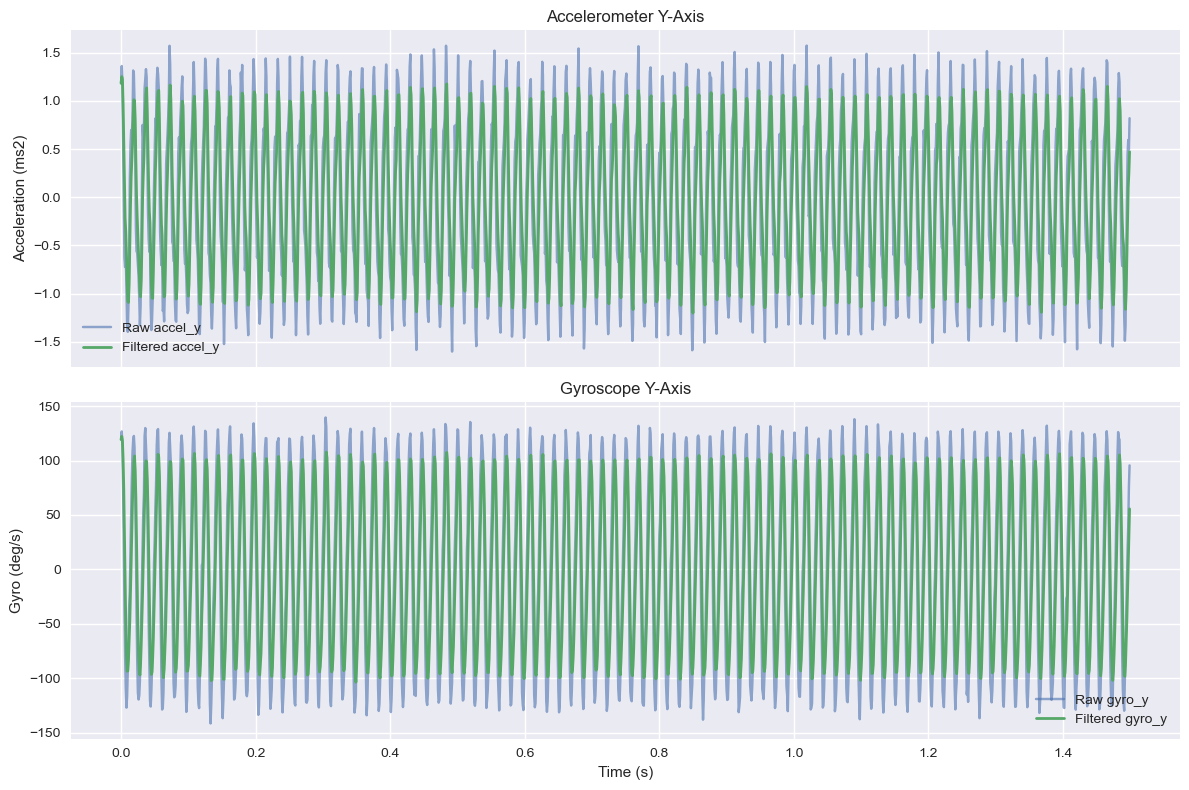

In [32]:
time_s = df['loop'] / 1000.0

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axes[0].plot(time_s, df['accel_y_ms2'], label='Raw accel_y', alpha=0.6)
axes[0].plot(time_s, filtered_df['accel_y_ms2'], label='Filtered accel_y', linewidth=2)
axes[0].set_ylabel('Acceleration (ms2)')
axes[0].legend()
axes[0].set_title('Accelerometer Y-Axis')

axes[1].plot(time_s, df['gyro_y_dps'], label='Raw gyro_y', alpha=0.6)
axes[1].plot(time_s, filtered_df['gyro_y_dps'], label='Filtered gyro_y', linewidth=2)
axes[1].set_ylabel('Gyro (deg/s)')
axes[1].set_xlabel('Time (s)')
axes[1].legend()
axes[1].set_title('Gyroscope Y-Axis')

plt.tight_layout()
plt.show()


## Save Filtered Output (Optional)
You can persist the filtered signals for downstream processing.

In [33]:
OUTPUT_PATH = Path('/Users/erickli/Desktop/Machine-Learning-for-Smart-Fitness-Pod/datasets/processed/xiao_nr52840_sense_imu_sample_filtered.csv')
filtered_df.to_csv(OUTPUT_PATH, index=False)
OUTPUT_PATH

PosixPath('/Users/erickli/Desktop/Machine-Learning-for-Smart-Fitness-Pod/datasets/processed/xiao_nr52840_sense_imu_sample_filtered.csv')